# Utility

In [1]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
help(robot_utils)

open3d :0.12.0
trimesh:3.8.19
numba  :0.52.0
Help on module robot_utils:

NAME
    robot_utils

CLASSES
    builtins.dict(builtins.object)
        Unit
        VolumeMesh
    builtins.object
        Joint
        URDF
    networkx.classes.digraph.DiGraph(networkx.classes.graph.Graph)
        RobotDescription
    
    class Joint(builtins.object)
     |  Joint(left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |  
     |  Methods defined here:
     |  
     |  __init__(s, left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __repr__(s)
     |      Return repr(self).
     |  
     |  toDict(s)
     |  
     |  tolist(s)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     | 

# Leg generation

Only need to run once

In [105]:
import cadquery as cq
from math import atan2,pi

leg_d0 = 0.05+2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
# leg_d1 = 240  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = leg_r1   # radius of the end at the second segment
leg_r3 = 24   # radius at the end of the last segment

leg_a0_deg = 90
leg_a0 = leg_a0_deg*pi/180. # mid section rotation angle

taper_angle = atan2(leg_r2-leg_r3,leg_d1) # taper angle [rad] of last section

leg_fillet = 24 # fillet at the end of the leg
leg_innercut_ratio =0.5

def makeLeg(d0 = leg_d0,# length of first segment
#             joint_overlap = joint_overlap, #overlap of the joint
            d1 = leg_d1,# length of last segment
            r0 = leg_r0,# radius of rotation of mid segment
            r1 = leg_r1,# radius of the first segment
            taper = taper_angle,# taper angle [rad] of last section
            r_fillet = leg_fillet,# fillet at last section
            innercut_ratio = leg_innercut_ratio
            ):
#     path = cq.Workplane("XY").center(0, 0).line(d0,0)\
#        .radiusArc((r0+leg_d0,r0),-r0)
    path = cq.Workplane("XY").center(0, 0).radiusArc((r0,r0),-r0)
    result = cq.Workplane("YZ").circle(r1).sweep(path) # first+mid section
#     result = result.faces("<X").circle(r1).extrude(-joint_overlap) # joint overlap section
    result = result.faces(">Y").workplane(centerOption="CenterOfMass").tag("midplane")\
        .circle(r1).extrude(d1,taper=taper*180./pi)\
        .faces(">Y").edges().fillet(r_fillet) # last section fillet
    result = result.workplaneFromTagged("midplane")\
        .circle(r1*innercut_ratio).cutBlind(d1+1,taper=taper*180./pi)
    return result

leg = makeLeg()
# show_object(leg)
cq.exporters.export(leg,"../../mesh/leg_simplified.step")
# cq.exporters.export(leg,"../../mesh/leg_simplified.stl")

In [106]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(12.5) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.5
min_radius = radius_knn*0.2
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

half_joint_overlap = radius_poisson * 0
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")

# general argument
gmsh_args = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
        ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
        ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap

    
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
#         ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
    
        ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
        ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
        ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature
        
        ("Mesh.RefineSteps",20), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10

#         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
        ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
#         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

# 2D specific argument
gmsh_args_2d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.4),
        ("Mesh.MeshSizeMax", radius_poisson*1.4),
] 

# 3D specific argument
gmsh_args_3d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.0),
]

gmsh_args = gmsh_args+gmsh_args_2d # combined

# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

32.47595264191645
10
5.0
joint_overlap:0.0


# Leg discretization

Only need to run once

# vertices          = 235
# surface triangle  = 410
# tetra             = 732
# unique tetra edges= 1171
# unique face edges = 615
COM                 =  [32.732 59.098 -0.006]
COM norm            = 67.557
mean edge length    = 17.47


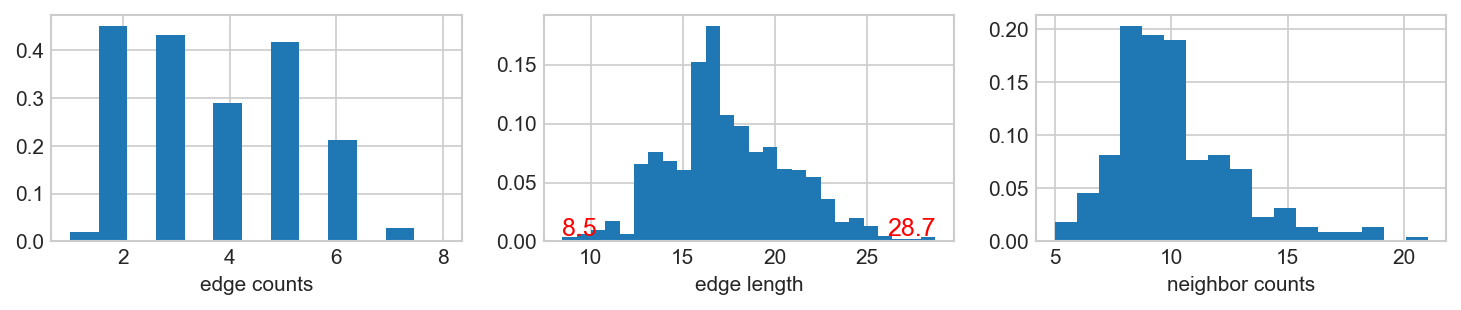

In [107]:
in_file_name: str = "../../mesh/leg_simplified.step"
out_file_name: str = "../../mesh/leg_simplified.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,dim=3,gui=False)
# # optimze vertices location
# n_jobs = int(multiprocessing.cpu_count()*0.2)
# total_jobs = int(n_jobs*1)
# # print(n_jobs,total_jobs)
# result = Parallel(n_jobs=n_jobs)(delayed(generateGmsh)(in_file_name,None) for i in range(total_jobs))
# mse_list = [np.linalg.norm(np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0)[1:]) for vmesh,_ in result]
# vmesh,best_vmesh_name = result[np.argmin(mse_list)]
# shutil.copyfile(best_vmesh_name,out_file_name) # copy the temp file to the out file
vmeshSummary(vmesh)

# with np.printoptions(precision=3, suppress=True):
#     print("COM at 1st section:",np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0))    

# Body discretization

Only need to run once

# vertices          = 1531
# surface triangle  = 2612
# tetra             = 5172
# unique tetra edges= 8005
# unique face edges = 3918
COM                 =  [-0.205 -0.274  0.177]
COM norm            = 0.386
mean edge length    = 16.94


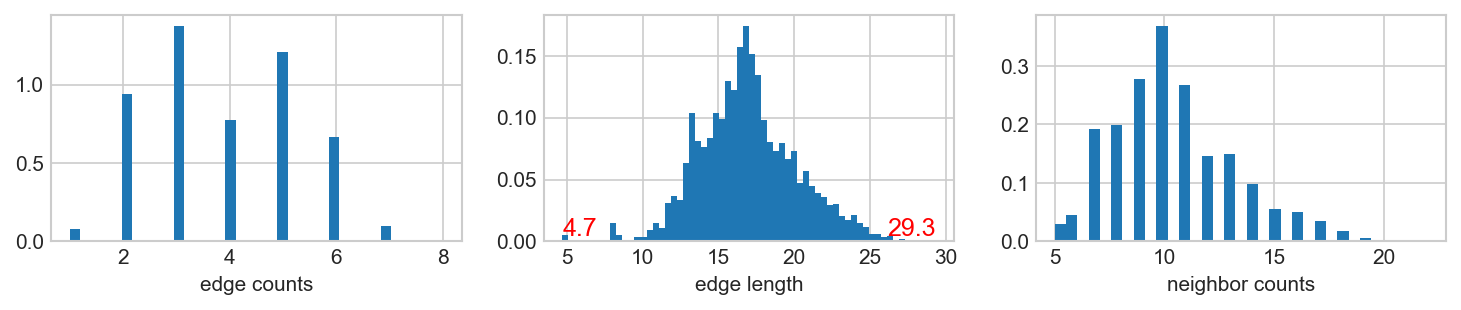

In [109]:
# discretize body
in_file_name: str = "../../mesh/soft_body_simplified.step"
out_file_name: str = "../../mesh/soft_body_simplified.msh"
vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=False)
# print(vmesh)
vmeshSummary(vmesh)

### load descritized leg

# vertices         = 235
# surface triangle = 410
# tetra            = 732
# unique edges     = 2761


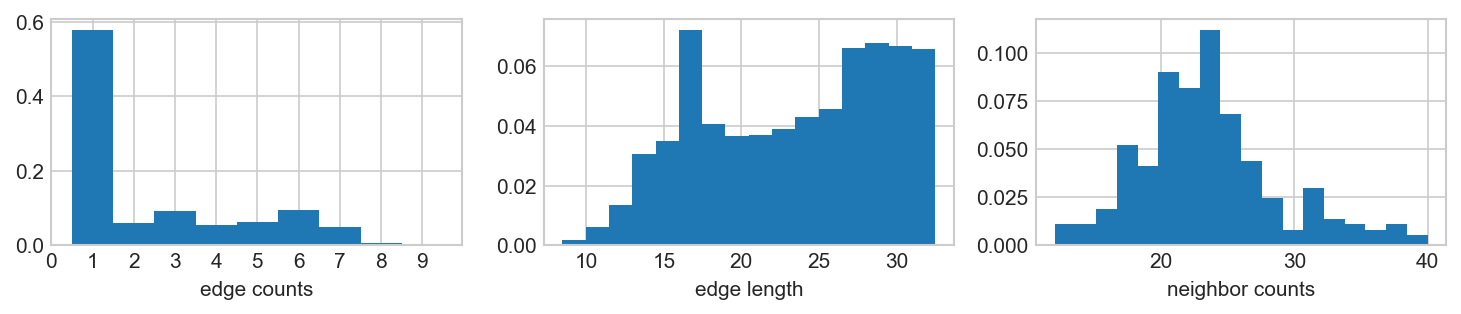

In [108]:
# %load_ext line_profiler
# %lprun -f descretize vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = descretize(msh_file="../../mesh/leg_simplified.msh")
# transform = np.array([
#     [0, 0,1],
#     [0, 1,0],
#     [1,0,0],
# ])

vmd_leg = descretize(
    msh_file="../../mesh/leg_simplified.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))
    
# vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = descretize(
#     msh_file="../../mesh/leg_simplified.msh",transform = transform)

In [78]:
# new_vertices = equidistantCylinder(
#     r=radius_poisson*2*1.2, h=radius_poisson*4*1.2, dr=radius_poisson*1.2)
# new_vertices = applyTransform(new_vertices, np.array(
#     [[0, 0, 1],
#      [1, 0, 0],
#      [0, 1, 0]]))
# vmd_leg.appendVertices(
#     new_vertices, min_radius=0, max_radius=radius_knn, max_nn=max_nn)
# o3dShow([vmd_leg.pcd(), vmd_leg.lsd()])

### load descritized body

# vertices         = 1531
# surface triangle = 2612
# tetra            = 5172
# unique edges     = 17156


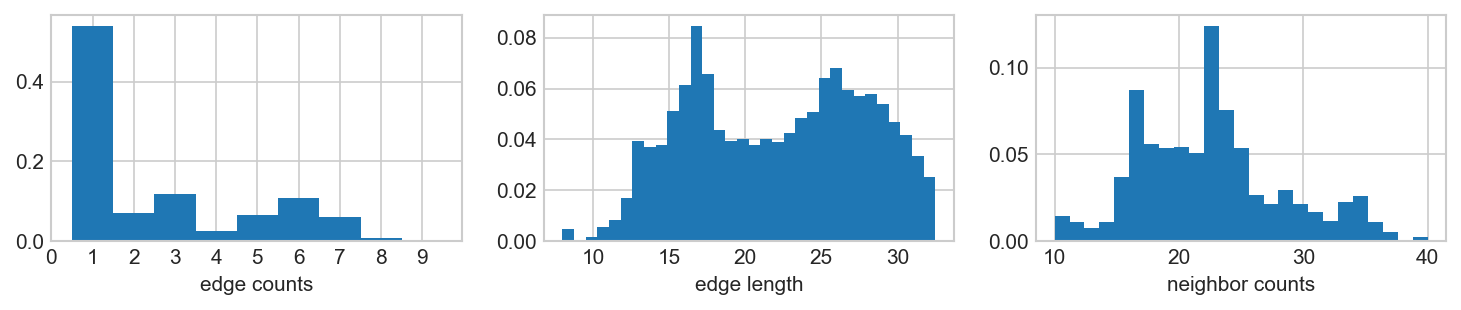

In [110]:
transform = np.array([[0, 0, 1, 0],
                      [1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 0, 1]], dtype=np.float64)
# x: back->front
# y: right->left
# z: down->top
vmd_body = descretize(
    msh_file="../../mesh/soft_body_simplified.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=transform)

In [80]:
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

# Assemble the parts

In [111]:
############################ defineing joints geometry
rot_ang = 10.0/189.*np.pi
cylinder_len = 103
dx = 260.0/2 + cylinder_len*np.sin(rot_ang)
dy = 0.0 + cylinder_len*np.cos(rot_ang)

########################################################
t_axial = translation((0,0,cylinder_len-half_joint_overlap)) # translate along cylinder
t_zrot = axisAngleRotation((0,0,1),np.pi)

t0 = translation((+dx,+dy,0)).dot(axisAngleRotation((0, 0, 1),-rot_ang+np.pi/2))# front left
t1 = translation((-dx,+dy,0)).dot(axisAngleRotation((0, 0, 1),+rot_ang+np.pi/2))# back left
t2 = translation((-dx,-dy,0)).dot(axisAngleRotation((0, 0, 1),-rot_ang-np.pi/2))# back right
t3 = translation((+dx,-dy,0)).dot(axisAngleRotation((0, 0, 1),+rot_ang-np.pi/2))# front right

{0: 'body', 1: 'leg_0', 2: 'leg_1', 3: 'leg_2', 4: 'leg_3'}
{0: ('body', 'leg_0'), 1: ('body', 'leg_1'), 2: ('body', 'leg_2'), 3: ('body', 'leg_3')}


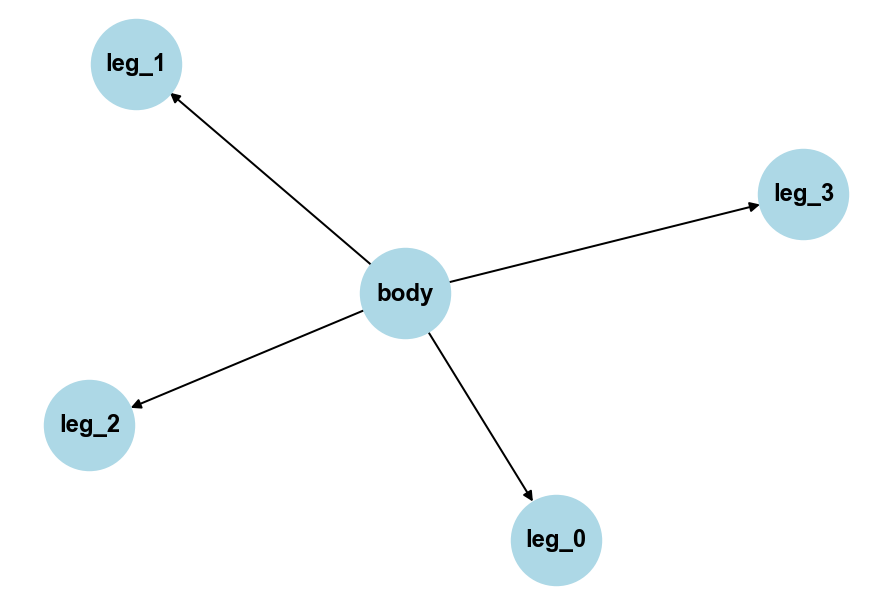

In [112]:
graph = RobotDescription(unit_dict={"length":"mm"})
graph.add_nodes_from([
    ("body", {"vmd": vmd_body.copy(),"color":(1,0,0,1),"density":600}),  # main_body
    ("leg_0", {"vmd": vmd_leg.copy(cmap ='spring'),"color":(0,1,0,1),"density":400}),  # front left
    ("leg_1", {"vmd": vmd_leg.copy(cmap ='summer'),"color":(0,1,0,1),"density":400}),  # back left
    ("leg_2", {"vmd": vmd_leg.copy(cmap ='autumn'),"color":(0,0,1,1),"density":400}),  # back right
    ("leg_3", {"vmd": vmd_leg.copy(cmap ='winter'),"color":(0,0,1,1),"density":400}),  # front right
#     ("leg_4", {"vmd": vmd_leg.copy(cmap ='winter'),"color":(0,0,1,1),"density":400}),  # front right
],
    transform = np.eye(4),
    density = 400., # kg/m^3
    color = np.array((1,1,1,1)) # white
)
graph.add_edges_from((
    ("body", "leg_0", {"transform": t0, "joint_pos": 0}),
    ("body", "leg_1", {"transform": t1, "joint_pos": 0}),
    ("body", "leg_2", {"transform": t2, "joint_pos": 0}),
    ("body", "leg_3", {"transform": t3, "joint_pos": 0}),
#     ("body", "leg_4", {"transform": t3, "joint_pos": np.pi/2}),
),
    transform=np.eye(4),
    joint_type="continuous",
    joint_pos=0, 
    axis=(1, 0, 0),
    limit = { # units must be SI here
        "effort":5, # torque, [Nm]
        "velocity":round(487/60*2*np.pi) # speed [rad/s]
    }
)
# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)

nx.draw(graph,nx.spring_layout(graph), with_labels=True, font_weight='bold',node_size=2000,node_color="lightblue")
################## computed value ###################################
graph.updateWorldTransform()
# list(nx.edge_bfs(graph))

#####################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(dict_id2node)
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(dict_id2edge)

graph.joint_pos = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])
# graph.joint_pos = np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])

In [113]:
graph.updateWorldTransform()

world_space_o3d_mesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_pcd = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

o3dShow(world_space_pcd+world_space_lsd+link_coordinate_frames+joint_coordiate_frams)
# o3dShow([world_space_pcd[0],world_space_lsd[0],world_space_o3d_mesh[0]])
# o3dShow([world_space_pcd[1],world_space_lsd[1]])

# create spring-mass representation

edge('body', 'leg_0'): ((42, 42)) already processed, skip this
edge('body', 'leg_1'): ((41, 41)) already processed, skip this
edge('body', 'leg_2'): ((41, 41)) already processed, skip this
edge('body', 'leg_3'): ((42, 42)) already processed, skip this
id_vertices=[   0 1615 1871 2126 2381 2637 2645 2708]
id_vertices labels:
('body', 0)
('leg_0', 1615)
('leg_1', 1871)
('leg_2', 2126)
('leg_3', 2381)
('anchor', 2637)
('coord', 2645)
('end', 2708)
--------------------
id_lines=[    0 18818 22005 25170 28332 31508 31512 32176 35366 35555 36500]
id_lines labels:
(('body', 'leg_0'), 0)
(('body', 'leg_1'), 18818)
(('body', 'leg_2'), 22005)
(('body', 'leg_3'), 25170)
('anchor_lines', 31508)
('rot_springs', 31512)
('fri_springs', 32176)
('coord_self_lines', 35366)
('coord_attach_lines', 35555)
('end', 36500)
--------------------


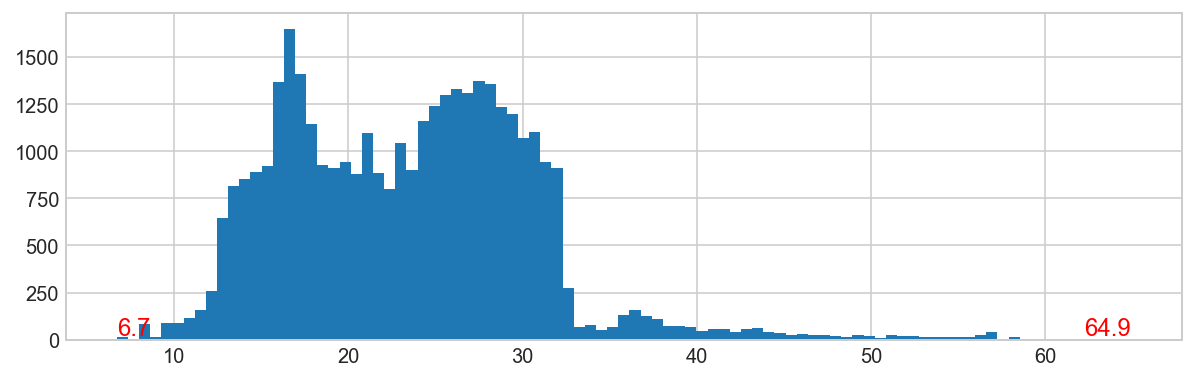

In [116]:
discretization_opt = dict(
    min_radius=min_radius, 
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 30,
    joint_height = 50,
    joint_sections = 30, # number of sections of the joint cylinder mesh
)

for e in graph.edges:
    graph.makeJoint(e, opt=discretization_opt)

########################################
graph.updateWorldTransform()

# number of attachment lines per point in the attached coordinates
num_attach_per_coord = 15

# ##################################################
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.edges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.edges]

# vertices:
# parts_xyzs = part_k_xyzs for k in range(#nodes)
# anchors_xyzs = anchor_k for k in range(#joints)
# coord_xys = coord(root_node), coord(joint_k_left),coord(joint_k_right), k in range(#joints)
# vertices = np.vstack(part_vertices + 
#                      anchor_vertices +
#                      part_coord_vertices + 
#                      joint_coord_vertices)

vertices = part_vertices + \
    [np.vstack(anchor_vertices)] +\
    [np.vstack(part_coord_vertices+joint_coord_vertices)]
id_vertices = np.hstack(([0], np.cumsum([len(v) for v in vertices])))
vertices = np.vstack(vertices)

id_vertices_label = [(n, id_vertices[k]) for k, n in enumerate(graph.nodes)] + \
    [("anchor", id_vertices[len(graph)]),
     ("coord", id_vertices[len(graph)+1]),
     ("end", id_vertices[len(graph)+2])]

# colors of the vertices
part_colors = np.vstack(
    [graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors


###################################################################
part_len = [len(v) for v in part_vertices]
anchor_len = [len(v) for v in anchor_vertices]
part_coord_len = [len(v) for v in part_coord_vertices]
joint_coord_len = [len(v) for v in joint_coord_vertices]

# id_vertices = np.hstack(
#     ([0], np.cumsum(part_len+anchor_len+part_coord_len+joint_coord_len)))

# vertex ids
vid_part = np.hstack(([0], np.cumsum(part_len)))  # vertex id part
vid_anchor = np.hstack(([0], np.cumsum(anchor_len))) + \
    vid_part[-1]  # vertex id anchor
vid_part_coord = np.hstack(([0], np.cumsum(part_coord_len))) + vid_anchor[-1]
vid_joint_coord = np.hstack(
    ([0], np.cumsum(joint_coord_len))) + vid_part_coord[-1]

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.edges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
# part surfaces
part_surface_id = np.hstack(
    [np.unique(graph.nodes[n]["vmd"]["triangles"].ravel()) +
     graph.nodes[n]["vertex_start_id"] for n in graph.nodes])
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True

###############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.edges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.edges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.edges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.edges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    joint_k = Joint(
        left=edge["id_joint_parent"]+vid_part[parent_id],
        right=edge["id_joint_child"]+vid_part[child_id],
        anchor=anchor_lines[k],
        left_coord=edge["coord_start_id"],
        right_coord=graph.nodes[child]["coord_start_id"],
        axis=edge["axis"]
    )
    lines_length = np.linalg.norm(vertices[joint_k.friSpring[:, 0]] -
                                  vertices[joint_k.friSpring[:, 1]], axis=1)
    joint_k.friSpring = joint_k.friSpring[lines_length > 0.3*radius_knn]
    joints.append(joint_k)

rot_springs = [j.rotSpring for j in joints]
fri_springs = [j.friSpring for j in joints]

# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines = part_lines +\
    [np.vstack(anchor_lines)] +\
    [np.vstack(rot_springs)] +\
    [np.vstack(fri_springs)] +\
    [np.vstack(coord_self_lines)] +\
    [np.vstack(coord_attach_lines)]

# start, end of respective lines
id_lines = np.hstack(([0], np.cumsum([len(v) for v in lines])))

lines = np.vstack(lines)

id_lines_label = [(n, id_lines[k]) for k, n in enumerate(graph.edges)] + \
    [("anchor_lines", id_lines[len(graph)]),
     ("rot_springs", id_lines[len(graph)+1]),
     ("fri_springs", id_lines[len(graph)+2]),
     ("coord_self_lines", id_lines[len(graph)+3]),
     ("coord_attach_lines", id_lines[len(graph)+4]),
     ("end", id_lines[len(graph)+5])]

print(f"id_vertices={id_vertices}")
print("id_vertices labels:",*id_vertices_label,"-"*20, sep = "\n")

print(f"id_lines={id_lines}")
print("id_lines labels:",*id_lines_label,"-"*20, sep = "\n")

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [119]:
# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))

# o3dShow(robot_lsd)

# robot_triangles = o3d.geometry.TriangleMesh(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector3iVector(triangles))
# robot_triangles.compute_triangle_normals()
# robot_triangles.vertex_colors =  o3d.utility.Vector3dVector(colors)
# o3dShow(robot_triangles)

In [121]:
# export

xyz_all_trans = vertices.copy()
min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+0]))/1000

joints_list = [joint.tolist() for joint in joints]

data = [
    radius_poisson*1e-3,# convert to m
    xyz_all_trans.tolist(),
    lines.tolist(),
    triangles.tolist(),
    is_surface.tolist(),
    
    id_vertices.tolist(),
#     vid_part.tolist(),
#     vid_anchor.tolist(),
#     vid_part_coord.tolist(),
#     vid_joint_coord.tolist(),
    
    id_lines.tolist(),
    
    colors.tolist(),
    joints_list
]

# joints_list = [joint.toDict() for joint in joints]

# data ={
#     "vertices":xyz_all_trans.tolist(),
#     "lines":lines.tolist(),
#     "isSurface":is_surface.tolist(),
#     "idVertices":id_vertices.tolist(),
#     "idEdges":id_lines.tolist(),
#     "colors":colors.tolist(),
#     "Joints":joints_list,
# }

print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(xyz_all_trans),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))

# o3dShow(robot_lsd)


# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack

# Write msgpack file
with open('../data.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../data.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.18488844 -0.17061553  0.        ]
[0.18488844 0.17061553 0.1904335 ]
(2708, 3)
(36500, 2)


# The rest part are not ready

In [43]:
import orjson
joints_list = [joint.toDict() for joint in joints]

data ={
    "vertices":xyz_all_trans,
    "lines":lines,
    "isSurface":is_surface,
    "idVertices":id_vertices,
    "idEdges":id_lines,
    "colors":colors,
    "Joints":joints_list,
}
with open('../data.json','wb') as data_file:
    packed = orjson.dumps(data, option=orjson.OPT_SERIALIZE_NUMPY)
    data_file.write(packed)
    
with open("../data.json", "rb") as f:
    json_data = orjson.loads(f.read())


In [44]:
# vertices_joint = np.vstack((parent_vertices[is_joint_parent],child_vertices_t[is_joint_child]))
# pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices_joint))
# o3dShow(pcd)

In [45]:
# mesh = copy.deepcopy(vmd.triMesh())
# mesh.density = 1000
# mesh.vertices = mesh.vertices*1e-3
# mesh = mesh.simplify_quadratic_decimation(len(mesh.faces)*0.4)
# _ = mesh.export(file_obj="./mesh.stl")

In [132]:
print(dict(enumerate(self.nodes)))
print(dict(enumerate(self.edges)))

{0: 'body', 1: 'leg_0', 2: 'leg_1', 3: 'leg_2', 4: 'leg_3'}
{0: ('body', 'leg_0'), 1: ('body', 'leg_1'), 2: ('body', 'leg_2'), 3: ('body', 'leg_3')}


In [ ]:
leg_axes_transform = [t0,t1,t2,t3]


joint_radius = radius_poisson*3
# joint_radius = leg_r1
print(f"joint_radius={joint_radius}")
# cylinders for getting the rotation anchor points on the body
cylinders = [trimesh.creation.cylinder(radius=joint_radius, height=joint_overlap+80, transform=t,sections=60)\
             for t in leg_axes_transform]
##################################################################################################################


def LegAlignTransform(rot_angle):
    """
    first align the rotational axis to z-axis, next rotate about the z axis for rot_angle,
    finally translate along z-axis
    """
#     return translation((0,0,half_joint_overlap), # translate along z-axis
#                      np.dot(axisAngleRotation((0,0,1),rot_angle),# rotate about the z axis for rot_angle
#                             axisAngleRotation((0,1,0),-np.pi/2))) # align the rotational axis to z-axis
    return axisAngleRotation((1,0,0),rot_angle)

# define zero_leg_anges as the leg angles when all the legs are pointing towards front
zero_leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2]) 

# leg_angles = np.array([np.pi,np.pi,0,0]) # four leg standing
# leg_angles = np.array([np.pi/8,np.pi/8,np.pi/8,np.pi/8])

# leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2])
# leg_angles = np.array([0,0,np.pi,np.pi])

leg_angles = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2]) 
# leg_angles = np.array([0,0,0,0])

initial_leg_angles = leg_angles-zero_leg_angles


# axis for the joint - body
leg_transform = [np.dot(t,LegAlignTransform(angle)) for t,angle in zip(leg_axes_transform,leg_angles)]

# axis for the legs
aligned_leg_axes_transform = leg_transform


# coordinates for the joint - body
coord_joint_left = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in leg_axes_transform]

# coordinate for the joint - legs
coord_joint_right = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in aligned_leg_axes_transform]

legs = [o3d.geometry.PointCloud(pcd_leg).transform(t) for t in leg_transform]
lsd_legs = [o3d.geometry.LineSet(lsd_leg).transform(t) for t in leg_transform]


cmap_str = ("spring","summer","autumn","winter")
for k in range(len(legs)):
    legs[k],lsd_legs[k] = ColorizePcdAndLsd(nsd_leg,legs[k],lsd_legs[k],plt.cm.get_cmap(cmap_str[k]))

    
coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd_body,coord_frame]+coord_joint_left+coord_joint_right+legs)

In [230]:
# o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+coord_joint_right+legs)
# o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+legs)

# o3d.visualization.draw_geometries([pcd_body,lsd_body,coord_body]+coord_joint_left+legs+lsd_legs)


o3d.visualization.draw_geometries([pcd_body,coord_frame]+coord_joint_right+legs)

# o3d.visualization.draw_geometries(coord_joint_left+legs)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left)
# o3d.visualization.draw_geometries([pcd_body,lsd_body]+legs+lsd_legs+coord_joint_left)
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,lsd_body]+legs+lsd_legs,rotate_view)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left+legs)

In [153]:
# # axes_all = [axis_body, axis_leg0, axis_leg1, axis_leg2, axis_leg3]
# axes_all = [coord_frame] + coord_joint_left

# pcd list of parts
pcd_parts = [pcd_body]+legs 

# lst list of parts
lsd_parts = [lsd_body]+lsd_legs

# # transform_all = [transform_body, transform_leg0, transform_leg1, transform_leg2, transform_leg3]
# transform_all = [np.eye(4)] + leg_axes_transform

# list of boolean array for the rotation ids of the body, 4 in total
body_rot_ids = [cylinder.ray.contains_points(pcd_body.points) for cylinder in cylinders]

# list of np boolean array indicating if point is part of rotational jonit
# leg_rot_ids = [np.asarray(pcd_leg_d.points)[:,0]<-leg_d0,]*len(legs)

# pcd_leg_points = np.asarray(pcd_leg.points)
# leg_rot_ids = [
#     np.logical_and(pcd_leg_points[:, 0] <= 0,
#                    (pcd_leg_points[:, 1]**2 +
#                    pcd_leg_points[:, 2]**2) <= (joint_radius)**2
#                    )]*len(legs)
leg_rot_ids = [cylinder.ray.contains_points(np.asarray(leg.points)) for cylinder,leg in zip(cylinders,legs)]


# xyzs of the components [body,leg,leg,leg,leg]
xyz_parts = [np.asarray(pcd.points) for pcd in pcd_parts]

# the edges of the points start and end index for each part of the component
id_xyz_parts_edges = np.cumsum([0]+[len(xyz) for xyz in xyz_parts])
print(f"id_xyz_parts_edges={id_xyz_parts_edges}")

# lines of the components [body,leg,leg,leg,leg]
lines_parts = [np.asanyarray(lsd.lines) for lsd in lsd_parts]

id_lines_parts_edges = np.cumsum([0]+[len(lines) for lines in lines_parts])
print(f"id_lines_parts_edges={id_lines_parts_edges}")


n_parts = len(xyz_parts) # number of components
print(f"n_parts={n_parts}")
n_joints = len(legs)
print(f"n_joints={n_joints}")

# array of index of the componet for a joint
id_joint_components = np.array([[0,1],[0,2],[0,3],[0,4]])

# list of transform for each joint
joint_transforms_body = leg_axes_transform
joint_transforms_leg = aligned_leg_axes_transform

# the actual points (bool array)
joint_tuples = list(zip(body_rot_ids,leg_rot_ids))

rot_anchor_radius = half_joint_overlap+radius_poisson*0.5
# rot_anchor_radius = 20
print(f"rot_anchor_radius={rot_anchor_radius}")

# anchor points for each of the rotational joint
rot_anchors = [applyTransform([[0,0,-rot_anchor_radius],
                               [0,0,rot_anchor_radius]],t) 
               for t in leg_axes_transform]
# print(rot_anchors)

# create pointcloud for anchors
pcd_anchors = o3d.geometry.PointCloud()
pcd_anchors.points = o3d.utility.Vector3dVector(np.vstack(rot_anchors))
pcd_anchors.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_anchors.points), 1)))

[sum(ids) for ids in body_rot_ids],[sum(ids) for ids in leg_rot_ids]

id_xyz_parts_edges=[   0 2289 2684 3079 3474 3869]
id_lines_parts_edges=[    0 21857 25893 29929 33965 38001]
n_parts=5
n_joints=4
rot_anchor_radius=5.0


([44, 44, 47, 46], [54, 54, 54, 54])

In [154]:
# pcd_body.paint_uniform_color([0, 1, 0])

# for k in range(4):
#     legs[k].paint_uniform_color([0, 1, 0])
#     np.asarray(legs[k].colors)[leg_rot_ids[k]] = np.array((1,0,0))
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = np.array((0,0,1))

# o3d.visualization.draw_geometries(legs+[pcd_body],point_show_normal=False)

In [155]:
# o3d.visualization.draw_geometries([pcd_body],point_show_normal=False)

In [36]:
# axis_size=5
# axis_origin_tri = trimesh.creation.axis(axis_size*2)
# # front left, back left, front right, back right
# axes = [trimesh.creation.axis(axis_size,transform=t) for t in leg_axes_transform]
# body_trimesh.visual.face_colors=(102, 102, 102, 255)
# pcd_body_trimesh = trimesh.points.PointCloud(np.asarray(pcd_body.points))
# pcd_body_trimesh.visual.vertex_colors = (0, 102, 102, 255)

# legs_trimesh = [trimesh.points.PointCloud(np.asarray(leg.points)) for leg in legs]
# for leg_trimesh in legs_trimesh:
#     leg_trimesh.visual.vertex_colors = np.array((255, 1, 1, 255))
    
# for cylinder in cylinders:
#     cylinder.visual.vertex_colors = np.array((255, 1, 1, 255))

# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,body_trimesh]+cylinders)
# scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,pcd_body_trimesh]+cylinders)
# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri]+cylinders+legs_trimesh)
# scene.show()

In [156]:
class Coord:# coordinate
    def __init__(s, body_id, transform):
        """
        body_id: body index,e.g. mainbody=0,leg0=1,leg1=2,leg2=3,leg3=4
        transform: 4x4 numpy transform matrix
        """
        s.bodyId = body_id
        s.transform = transform
        s.oxyz = GetCoordinateOXYZ(transform)
        # index offset for the coordinate
        s.id_start = id_xyz_parts_edges[body_id]


coord_list = [
    Coord(0, body_transform),# body axis
    Coord(id_joint_components[0,0],joint_transforms_body[0]), # joint0-body axis
    Coord(id_joint_components[0,1],joint_transforms_leg[0]), # joint0-leg0 axis
    Coord(id_joint_components[1,0],joint_transforms_body[1]), # joint1-body axis
    Coord(id_joint_components[1,1],joint_transforms_leg[1]), # joint1-leg1 axis
    Coord(id_joint_components[2,0],joint_transforms_body[2]), # joint2-body axis
    Coord(id_joint_components[2,1],joint_transforms_leg[2]), # joint2-leg2 axis
    Coord(id_joint_components[3,0],joint_transforms_body[3]), # joint3-body axis
    Coord(id_joint_components[3,1],joint_transforms_leg[3])  # joint3-leg3 axis
]

# oxyzs: list of oxyz from coord_list
oxyzs = [c.oxyz for c in coord_list]

# # pcd of oxyzs
pcd_oxyzs = o3d.geometry.PointCloud()
pcd_oxyzs.points = o3d.utility.Vector3dVector(np.vstack(oxyzs))
pcd_oxyzs.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_oxyzs.points), 1)))
# o3d.visualization.draw_geometries([pcd_oxyzs])

In [157]:
# get all colors
pcds = [pcd_body]+legs+[pcd_anchors]+[pcd_oxyzs]
colors_all = np.vstack(list(map(np.asarray,[pcd.colors for pcd in pcds])))

# the acutal points list, arrange as
# [xyz_0,xyz_1,...,xyz_n,]+ [xyz_anchor_0,...,xyz_anchor_m] + [oxyz_0,oxyz_1,..]
xyzs = xyz_parts + rot_anchors + oxyzs

xyz_all = np.vstack(xyzs)

# the count of points in each component of xyzs
points_counts = [len(xyz) for xyz in xyzs]
print(f"points_counts={points_counts}")


# the edges of the points start and end index for each part of the component
# e.g. the idex of xyzs[k] start at id_xyzs_edges[k], and ends at id_xyzs_edges[k+1]
# the rot_anchors [j] start at id_xyzs_edges[n_parts+k], and ends at id_xyzs_edges[n_parts+k+1]
id_xyzs_edges = np.cumsum([0]+[len(xyz) for xyz in xyzs])
print(f"id_xyzs_edges={id_xyzs_edges}")
list(zip(id_xyzs_edges,"body,leg0,leg1,leg2,leg3,anchor0,anchor1,anchor2,anchor3,oxyz_body,\
oxyz_joint0_body,oxyz_joint0_leg0,oxyz_joint1_body,oxyz_joint1_leg1,\
oxyz_joint2_body,oxyz_joint2_leg2,oxyz_joint3_body,oxyz_joint3_leg3,\
the end".split(",")))

points_counts=[2289, 395, 395, 395, 395, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7]
id_xyzs_edges=[   0 2289 2684 3079 3474 3869 3871 3873 3875 3877 3884 3891 3898 3905
 3912 3919 3926 3933 3940]


[(0, 'body'),
 (2289, 'leg0'),
 (2684, 'leg1'),
 (3079, 'leg2'),
 (3474, 'leg3'),
 (3869, 'anchor0'),
 (3871, 'anchor1'),
 (3873, 'anchor2'),
 (3875, 'anchor3'),
 (3877, 'oxyz_body'),
 (3884, 'oxyz_joint0_body'),
 (3891, 'oxyz_joint0_leg0'),
 (3898, 'oxyz_joint1_body'),
 (3905, 'oxyz_joint1_leg1'),
 (3912, 'oxyz_joint2_body'),
 (3919, 'oxyz_joint2_leg2'),
 (3926, 'oxyz_joint3_body'),
 (3933, 'oxyz_joint3_leg3'),
 (3940, 'the end')]

In [158]:
id_xyzs_anchor_start = id_xyzs_edges[n_parts]
print(f"id_xyzs_anchor_start={id_xyzs_anchor_start}")

id_xyzs_oxyz_start = id_xyzs_edges[n_parts+n_joints]
print(f"id_xyzs_oxyz_start={id_xyzs_oxyz_start}")

id_xyzs_joint_oxyz_start = id_xyzs_edges[n_parts+n_joints+1]
print(f"id_xyzs_joint_oxyz_start={id_xyzs_joint_oxyz_start}")

id_xyzs_anchor_start=3869
id_xyzs_oxyz_start=3877
id_xyzs_joint_oxyz_start=3884


In [159]:
def GetNeighborsOXYZ(pcd,oxyz):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    oxyz_neighbors = [np.asarray(pcd_tree.search_knn_vector_3d(
        point,knn=20)[1]) for point in oxyz]
    return oxyz_neighbors
# oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd,oxyz))+id_start 
#                    for pcd,oxyz,id_start in zip(pcd_parts,oxyzs,id_xyzs_edges)]

oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd_parts[c.bodyId],c.oxyz))+c.id_start 
                   for c in coord_list]

In [160]:
# create oxyz_springs
oxyz_self_springs = []
oxyz_anchor_springs = []
for oxyz,oxyz_neighbor,oxyz_id_start in zip(oxyzs,oxyzs_neighbors,id_xyzs_edges[n_parts+n_joints:]):
    oxyz_id = np.array([oxyz_id_start+k for k in range(NUM_POINTS_PER_COORDINATE)]) # 7 points per coordinate: o,x,y,z,-x,-y,-z
    print(oxyz_id)
    oxyz_anchor_springs.append(
        np.vstack([getEdges(neighbor,point_id) for point_id,neighbor in zip(oxyz_id,oxyz_neighbor)]))
    oxyz_self_springs.append(oxyz_id[
        np.array((
    (0,1),#ox
    (0,2),#oy
    (0,3),#oz
    (0,4),#o-x
    (0,5),#o-y
    (0,6),#o-z
    (1,2),#xy
    (1,3),#xz
    (1,4),#x-x
    (1,5),#x-y
    (1,6),#x-z
    (2,3),#yz
    (2,4),#y-x
    (2,5),#y-y
    (2,6),#y-z
    (3,4),#z-x
    (3,5),#z-y
    (3,6),#z-z
    (4,5),#-x-y
    (4,6),#-x-z
    (5,6)#-y-z
    ))])
oxyz_self_springs = np.vstack(oxyz_self_springs)
oxyz_anchor_springs = np.vstack(oxyz_anchor_springs)

[3877 3878 3879 3880 3881 3882 3883]
[3884 3885 3886 3887 3888 3889 3890]
[3891 3892 3893 3894 3895 3896 3897]
[3898 3899 3900 3901 3902 3903 3904]
[3905 3906 3907 3908 3909 3910 3911]
[3912 3913 3914 3915 3916 3917 3918]
[3919 3920 3921 3922 3923 3924 3925]
[3926 3927 3928 3929 3930 3931 3932]
[3933 3934 3935 3936 3937 3938 3939]


21

In [161]:
oxyz_id

array([3933, 3934, 3935, 3936, 3937, 3938, 3939], dtype=int32)

In [233]:
# # ids of the leg at rotational joint
# # assume body index start at id_xyzs_edges[0]
# # leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
# joints = []
# for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
#     body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
#     leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
#     anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
#     # (left_ids,right_ids,anchors_id)
#     joints.append([body_rot_id_actual,leg_rot_id_actual,anchors_id])

# joints_list = [[m.tolist() for m in joint] for joint in joints]

In [162]:
def CreateJointLines(id_0, id_1, id_joint):
    """
    return the joint lines(rotation springs) defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
        id_joint: 2 indices of the end points of a joint
    """
    return np.vstack([np.column_stack([id_0, [id_joint[0]]*len(id_0)]), # left  (id_0) - axis_0
            np.column_stack([id_1, [id_joint[0]]*len(id_1)]), # left  (id_0) - axis_1
            np.column_stack([id_0, [id_joint[1]]*len(id_0)]), # right (id_1) - axis_0
            np.column_stack([id_1, [id_joint[1]]*len(id_1)])]) # right (id_1) - axis_1

def CreateJointFrictionSpring(id_0, id_1,num_spring_per_mass= 30):
    """
    return the friction springs defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
    """
    max_size = int((len(id_0)+len(id_1))*num_spring_per_mass/2)
    frictionSpring = np.vstack([np.column_stack([[id_0_k]*len(id_1),id_1]) for id_0_k in id_0])
    if frictionSpring.shape[0]>max_size:
        frictionSpring = frictionSpring[np.random.choice(frictionSpring.shape[0], max_size, replace=False)]
    return frictionSpring

In [163]:
class Joint:
    def __init__(s, left, right, anchor):
        s.left = np.copy(left)  # indices of the left mass
        s.right = right  # indices of the right mass
        s.anchor = anchor  # indices of the two ends of the center of rotation
        s.rotSpring = CreateJointLines(
            s.left, s.right, s.anchor)  # rotation spring
        s.friSpring = CreateJointFrictionSpring(
            s.left, s.right)  # friction spring
        s.leftCoord = None
        s.righCoord = None

    def __repr__(s):
        s_rotationSpring = np.array2string(
            s.rotSpring, threshold=10, edgeitems=2).replace("\n", ",")
        s_frictionSpring = np.array2string(
            s.friSpring, threshold=10, edgeitems=2).replace("\n", ",")

        return f"{{left({len(s.left)}):  {np.array2string(s.left,threshold=10,edgeitems=5)}\n" +\
               f" right({len(s.right)}): {np.array2string(s.right,threshold=10,edgeitems=5)}\n" +\
            f" anchor(2): {s.anchor}\n" +\
               f" leftCoord: {s.leftCoord}\n" +\
            f" righCoord: {s.righCoord}\n" +\
            f" rotSpring({len(s.rotSpring)}):{s_rotationSpring}\n" +\
            f" friSpring({len(s.friSpring)}):{s_frictionSpring}}}"

    def tolist(s):
        return [s.left.tolist(), s.right.tolist(), s.anchor.tolist(), int(s.leftCoord), int(s.righCoord)]

In [164]:
# ids of the leg at rotational joint
# assume body index start at id_xyzs_edges[0]
# leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
joints = []
for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
    body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
    leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
    anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
    # (left_ids,right_ids,anchors_id)
    
    joints.append(Joint(body_rot_id_actual,leg_rot_id_actual,anchors_id))

for k in range(n_joints):
    joints[k].leftCoord = id_xyzs_joint_oxyz_start+NUM_POINTS_PER_COORDINATE*2*k
    joints[k].righCoord = id_xyzs_joint_oxyz_start+(NUM_POINTS_PER_COORDINATE*2)*k + NUM_POINTS_PER_COORDINATE
    
joints_list = [joint.tolist() for joint in joints]
joints

[{left(44):  [1355 1356 1357 1358 1359 ... 2115 2137 2138 2145 2153]
  right(54): [2519 2520 2529 2531 2535 ... 2677 2678 2679 2680 2683]
  anchor(2): [3869 3870]
  leftCoord: 3884
  righCoord: 3891
  rotSpring(196):[[1355 3869], [1356 3869], ..., [2680 3870], [2683 3870]]
  friSpring(1470):[[2064 2643], [1363 2683], ..., [2137 2520], [2113 2668]]},
 {left(44):  [ 560  561  562  563  564 ... 2191 2192 2193 2197 2204]
  right(54): [2914 2915 2924 2926 2930 ... 3072 3073 3074 3075 3078]
  anchor(2): [3871 3872]
  leftCoord: 3898
  righCoord: 3905
  rotSpring(196):[[ 560 3871], [ 561 3871], ..., [3075 3872], [3078 3872]]
  friSpring(1470):[[ 579 3050], [ 565 3042], ..., [ 575 2950], [ 568 3030]]},
 {left(47):  [ 456  457  458  459  460 ... 2280 2281 2282 2283 2284]
  right(54): [3309 3310 3319 3321 3325 ... 3467 3468 3469 3470 3473]
  anchor(2): [3873 3874]
  leftCoord: 3912
  righCoord: 3919
  rotSpring(202):[[ 456 3873], [ 457 3873], ..., [3470 3874], [3473 3874]]
  friSpring(1515):[[ 4

In [165]:
# array of (the index of the axis points of a joint)
id_joint_keypoints = np.vstack([joint.anchor for joint in joints])
print(f"id_joint_keypoints:\n{id_joint_keypoints}")
# [body_lines,leg_lines_0,leg_lines_1,leg_lines_2,leg_lines_3]
lines_component_list = [lines + id_start for lines,
              id_start in zip(lines_parts, id_xyzs_edges)]

lines_joint_rotation = np.vstack([joint.rotSpring for joint in joints])

lines_joint_friction = np.vstack([joint.friSpring for joint in joints])
# list of all the edges of the assembly

lines_all_list = lines_component_list+[id_joint_keypoints,lines_joint_rotation,lines_joint_friction,
                                       oxyz_self_springs,oxyz_anchor_springs]
lines_all = np.vstack(lines_all_list)

id_lines_edges = np.cumsum([0]+[len(lines) for lines in lines_all_list])
print(f"id_lines_edges:{id_lines_edges}")
id_lines_edges[n_parts]

list(zip(id_lines_edges,"body,leg0,leg1,leg2,leg3,anchors,rotsprings,\
fricsprings,oxyz_self_springs,oxyz_anchor_springs,the end".split(',')))

id_joint_keypoints:
[[3869 3870]
 [3871 3872]
 [3873 3874]
 [3875 3876]]
id_lines_edges:[    0 21857 25893 29929 33965 38001 38005 38799 44754 44943 46203]


[(0, 'body'),
 (21857, 'leg0'),
 (25893, 'leg1'),
 (29929, 'leg2'),
 (33965, 'leg3'),
 (38001, 'anchors'),
 (38005, 'rotsprings'),
 (38799, 'fricsprings'),
 (44754, 'oxyz_self_springs'),
 (44943, 'oxyz_anchor_springs'),
 (46203, 'the end')]

In [166]:
# # np.asarray(pcd_body.colors)[np.sum(body_rot_ids,axis = 0,dtype=bool)]=(0,255,0)
# for k in range(4):
#     np.asarray(legs[k].colors)[leg_rot_id] = (0,255,0)
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = (0,0,255)

In [167]:
pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)

lsd_assembly = o3d.geometry.LineSet()
lsd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[n_parts]:])

lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all)

# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[6]:id_lines_edges[7]]) #joint rotspring
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[7]:id_lines_edges[8]]) #joint friciton spring


# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_self_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_anchor_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(np.vstack((oxyz_anchor_springs,oxyz_self_springs)))

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all[lines_all[:,0]]+colors_all[lines_all[:,1]])/2)
# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries_with_animation_callback([pcd_assembly,lsd_assembly,coord_body]+coord_joint_left,rotate_view)


In [168]:
print("#springs =%i"%(len(lines_all)))
print("#mass =%i"%(len(xyz_all)))

# # KDTree for nearest neighbor search
# pcd_assembly_tree = o3d.geometry.KDTreeFlann(pcd_assembly)

# # o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

# neighbors = [np.asarray(pcd_assembly_tree.search_radius_vector_3d(point, radius_knn)[1])
#              for point in xyz_all]
# # neighbors = [np.asarray(pcd_assembly_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 27))[1] for point in xyz_all]

# # check the distance of the springs
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,_ =ax.hist(np.linalg.norm(xyz_all[lines_all[:,0]] - xyz_all[lines_all[:,1]],axis=1),bins=200)
# ax.text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.set_xlabel("spring length")
# ax.set_ylabel("count")
# plt.show()

# neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
# print(f"mean neighbors ={np.mean(neighbor_counts)}")
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(neighbor_counts,bins=28,range=(0,28))
# ax.set_xlabel("#neighbors (including self)")
# ax.set_ylabel("count")
# # ax.text(surface_neighbor_threshold,0,f"{surface_neighbor_threshold}",ha="center",va="top",fontsize="x-large",color='r')
# plt.show()



# # average divergence of the neighbors from a point
# average_divergence = np.linalg.norm([xyz_all[n].mean(axis=0)-xyz_all[n[0]] for n in neighbors],axis=1)
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(average_divergence,bins=100)
# ax.set_xlabel("mean divergence of neighbors (including self)")
# ax.set_ylabel("count")
# plt.show()

# # is_suface is boolean array to specify wether the point is near the surface, useful for applying contraints
# surface_neighbor_threshold = int(max_nn*0.9)
# is_suface = np.logical_or(average_divergence>0.6*radius_poisson,neighbor_counts<surface_neighbor_threshold)
# is_suface[id_xyzs_edges[n_parts]:]=False # only body parts are considered
# print(f"%surface points = {is_suface.sum()/len(is_suface)*100:.0f}%")

#springs =46203
#mass =3940


In [169]:
is_suface = np.ones(len(xyz_all),dtype=bool)

# is_suface = np.zeros(len(xyz_all),dtype=bool)
# is_suface[id_xyzs_edges[0]:id_xyzs_edges[1]]=is_surface_body
# for k in range(4):
#     is_suface[id_xyzs_edges[1+k]:id_xyzs_edges[2+k]]=is_surface_leg

# colors_all_check = np.copy(colors_all)
# colors_all_check[is_suface]=(1,0.2,0.2)
# colors_all_check[~is_suface]=(0,0,0.1)

# pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all_check)
# lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all_check[lines_all[:,0]]+colors_all_check[lines_all[:,1]])/2)

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries([pcd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)

# export assembly

In [170]:
# transoformed so that z is pointed up
xyz_all_trans = applyTransform(xyz_all,
                               np.array([[0, 1, 0],
                                         [0, 0, 1],
                                         [1, 0, 0]]).T)

# xyz_all_trans = xyz_all.copy() # stand pose

min_bound = xyz_all_trans.min(axis=0)

# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+0]))/1000

# rotation about z
# xyz_all_trans =applyTransform(xyz_all_trans, axisAngleRotation([0,0,1],-20*np.pi/180))


pcd_assembly = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(xyz_all_trans))
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)
lsd_assembly = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(xyz_all_trans),
    o3d.utility.Vector2iVector(lines_all),
)
lsd_assembly.colors = o3d.utility.Vector3dVector(colors_all[lines_all].mean(axis=1))

coord_frame_mm = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.06, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly, coord_frame_mm])

data = [
    xyz_all_trans.tolist(),
    lines_all.tolist(),
    is_suface.tolist(),
    id_xyzs_edges.tolist(),
    id_lines_edges.tolist(),
    colors_all.tolist(),
    joints_list
]
print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines_all.shape)


# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack

# Write msgpack file
with open('../data.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)

[-0.18676242 -0.17285726  0.        ]
[0.18676242 0.17285726 0.19133422]
(3940, 3)
(46203, 2)


In [148]:
colors_all[lines_all].mean(axis=1).shape

(44877, 3)

In [191]:
# Read msgpack file
with open('../data.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    data_loaded = msgpack.unpack(data_file)
print(len(data_loaded[1]))

69886


In [102]:
# x = b'\x01\x02'

# dt = np.dtype(np.uint16)
# dt = dt.newbyteorder('>')
# np.frombuffer(x,dtype=dt)

In [ ]:
mesh = trimesh.load("../../mesh/leg_simplified.stl", use_embree=True)
mesh_dict = mesh.to_dict()

bounds,xyz_grid_edge,xyz_grid_inside = voxelizeMesh(mesh)
##############################
# print(mesh.is_watertight)
# # make mesh white- ish
# mesh.visual.face_colors = (255,255,255,255)
# mesh.show()

####################################
n_jobs = int(multiprocessing.cpu_count()*0.2)
total_jobs = n_jobs*2
result = Parallel(n_jobs=n_jobs)(delayed(sample_helper)(
    mesh_dict, xyz_grid_edge, xyz_grid_inside) for k in range(total_jobs))

# find the leg that has the least deviation from the centerline in the first section
mse_list = [np.linalg.norm(np.mean(v[v[:,0]<=0],axis=0)[1:]) for v in result]
vertices = result[np.argmin(mse_list)]

with np.printoptions(precision=3, suppress=True):
    print("COM at 1st section:",np.mean(vertices[vertices[:,0]<=0],axis=0))
    print("COM:",np.mean(vertices,axis=0))
    
    
#########################################
signed_distance = trimesh.proximity.signed_distance(mesh,vertices)
nsd = normalize(signed_distance) # normalized_signed_distance

pcd_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))

cmap = plt.cm.get_cmap('plasma')
pcd_o3d.colors = o3d.utility.Vector3dVector(cmap(nsd)[:,:3])

# KDTree for nearest neighbor search
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in vertices]
edges = np.vstack([GetEdges(neighbor[:max_nn]) for neighbor in neighbors])
# trim springs outside the mesh
mid_points = GetMidpoints(vertices,edges)
is_inside=mesh.ray.contains_points(mid_points)
edges = edges[is_inside]


lsd_o3d = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(vertices), 
    o3d.utility.Vector2iVector(edges))
    
o3d.visualization.draw_geometries([pcd_o3d,lsd_o3d, coord_frame])

# URDF

In [11]:
# generate URDF
urdf_path = "../../data/urdf/test/robot.urdf"
graph.exportURDF(path= urdf_path)

URDF path:D:\repo\experimental_flexipod\data\urdf\test\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="body">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="1.0493661266032401"/>
      <inertia ixx="0.003682336055127085" ixy="1.889287194020446e-08" ixz="-1.4119084668537106e-08" iyy="0.013414836323379574" iyz="1.2091648358577654e-08" izz="0.016173870762905343"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
      <material name="#ff0000ff">
        <color rgba="1 0 0 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="leg_0">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.16622540161055388"/>
  

In [138]:
import numpy as np
import pybullet as p
import time
import pybullet_data
##########################################
urdf_path = "../../data/urdf/test/robot.urdf"
####################################################
gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
robot_id = p.loadURDF(urdf_path, physicsClientId=gui)
# ############# set joint position ####################
joint_pos = np.array([-np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2])
p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
# ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    p.stepSimulation(physicsClientId=gui)
    time.sleep(0.01)